# Objective: 
Develop a machine learning pipeline that classifies customer support tickets by their issue 
type and urgency level, and extracts key entities (e.g., product names, dates, complaint 
keywords). The file (ai_dev_assignment_tickets_complex_1000 ) is provided. 


In [1]:
pip install pandas numpy nltk scikit-learn xgboost gradio matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [19]:
# Import libraries for data handling, NLP, ML, and visualization
import pandas as pd
import numpy as np
import re
from datetime import datetime, date
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import gradio as gr
import json

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [20]:
# Load the dataset (assuming tab-separated CSV)
data= pd.read_excel('ai_dev_assignment_tickets_complex_1000.xls')

In [21]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ticket_id      1000 non-null   int64 
 1   ticket_text    945 non-null    object
 2   issue_type     924 non-null    object
 3   urgency_level  948 non-null    object
 4   product        1000 non-null   object
dtypes: int64(1), object(4)
memory usage: 39.2+ KB
None


In [22]:
print(data.head())

   ticket_id                                        ticket_text  \
0          1  Payment issue for my SmartWatch V2. I was unde...   
1          2  Can you tell me more about the UltraClean Vacu...   
2          3  I ordered SoundWave 300 but got EcoBreeze AC i...   
3          4  Facing installation issue with PhotoSnap Cam. ...   
4          5  Order #30903 for Vision LED TV is 13 days late...   

           issue_type urgency_level            product  
0     Billing Problem        Medium      SmartWatch V2  
1     General Inquiry           NaN  UltraClean Vacuum  
2          Wrong Item        Medium      SoundWave 300  
3  Installation Issue           Low      PhotoSnap Cam  
4       Late Delivery           NaN      Vision LED TV  


In [23]:
print(data.isnull().sum())

ticket_id         0
ticket_text      55
issue_type       76
urgency_level    52
product           0
dtype: int64


In [24]:
# Display unique values
print("\nUnique Issue Types:", data['issue_type'].unique())
print("Unique Urgency Levels:", data['urgency_level'].unique())
print("Unique Products:", data['product'].unique())


Unique Issue Types: ['Billing Problem' 'General Inquiry' 'Wrong Item' 'Installation Issue'
 'Late Delivery' 'Product Defect' nan 'Account Access']
Unique Urgency Levels: ['Medium' nan 'Low' 'High']
Unique Products: ['SmartWatch V2' 'UltraClean Vacuum' 'SoundWave 300' 'PhotoSnap Cam'
 'Vision LED TV' 'EcoBreeze AC' 'RoboChef Blender' 'FitRun Treadmill'
 'PowerMax Battery' 'ProTab X1']


In [31]:
# Handle missing values
data.fillna({
    'ticket_text': '',
    'issue_type': 'General Inquiry',
    'urgency_level': 'Medium'
}, inplace=True)

In [32]:
print(data.isnull().sum())

ticket_id                   0
ticket_text                 0
issue_type                  0
urgency_level               0
product                     0
has_billing_issue           0
has_inquiry_issue           0
has_wrong_item_issue        0
has_installation_issue      0
has_late_delivery_issue     0
has_product_defect_issue    0
has_account_access_issue    0
dtype: int64


In [34]:
# Custom stopwords excluding complaint terms
base_stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Assumes complaint_keywords is defined (from feature engineering)
custom_stopwords = base_stopwords - set(complaint_keywords)

# Preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in custom_stopwords]
    return ' '.join(tokens)

# Apply preprocessing
data['processed_text'] = data['ticket_text'].apply(preprocess_text)

# Display sample
print("\nSample Preprocessed Text:")
print(data[['ticket_text', 'processed_text']].head())


Sample Preprocessed Text:
                                         ticket_text  \
0  Payment issue for my SmartWatch V2. I was unde...   
1  Can you tell me more about the UltraClean Vacu...   
2  I ordered SoundWave 300 but got EcoBreeze AC i...   
3  Facing installation issue with PhotoSnap Cam. ...   
4  Order #30903 for Vision LED TV is 13 days late...   

                                      processed_text  
0  payment issue smartwatch v2 underbilled order ...  
1  tell ultraclean vacuum warranty also available...  
2  ordered soundwave 300 got ecobreeze ac instead...  
3  facing installation issue photosnap cam setup ...  
4  order 30903 vision led tv 13 day late ordered ...  


In [58]:
# Define keywords for each issue type
billing_keywords = ['billing', 'payment', 'refund', 'charge', 'not refunded', 'overbilled', 'underbilled']
inquiry_keywords = ['question', 'info', 'tell', 'details', 'warranty', 'available']
wrong_item_keywords = ['wrong', 'incorrect', 'different', 'not ordered']
installation_keywords = ['installation', 'setup', 'configure', 'fails', 'stuck', 'trouble']
late_delivery_keywords = ['late', 'delayed', 'not delivered', 'days late']
product_defect_keywords = ['defective', 'broken', 'malfunction', 'faulty', 'not working', 'damaged']
account_access_keywords = ['login', 'access', 'account', 'password', 'locked']

complaint_keywords = (billing_keywords + inquiry_keywords + wrong_item_keywords + installation_keywords +
                      late_delivery_keywords + product_defect_keywords + account_access_keywords)

# Feature functions 
def has_billing_issue(text):
    return 1 if any(keyword in text.lower() for keyword in billing_keywords) else 0

def has_inquiry_issue(text):
    return 1 if any(keyword in text.lower() for keyword in inquiry_keywords) else 0

def has_wrong_item_issue(text):
    return 1 if any(keyword in text.lower() for keyword in wrong_item_keywords) else 0

def has_installation_issue(text):
    return 1 if any(keyword in text.lower() for keyword in installation_keywords) else 0

def has_late_delivery_issue(text):
    return 1 if any(keyword in text.lower() for keyword in late_delivery_keywords) else 0

def has_product_defect_issue(text):
    return 1 if any(keyword in text.lower() for keyword in product_defect_keywords) else 0

def has_account_access_issue(text):
    return 1 if any(keyword in text.lower() for keyword in account_access_keywords) else 0

# Add new features to the dataset
data['has_billing_issue'] = data['ticket_text'].apply(has_billing_issue)
data['has_inquiry_issue'] = data['ticket_text'].apply(has_inquiry_issue)
data['has_wrong_item_issue'] = data['ticket_text'].apply(has_wrong_item_issue)
data['has_installation_issue'] = data['ticket_text'].apply(has_installation_issue)
data['has_late_delivery_issue'] = data['ticket_text'].apply(has_late_delivery_issue)
data['has_product_defect_issue'] = data['ticket_text'].apply(has_product_defect_issue)
data['has_account_access_issue'] = data['ticket_text'].apply(has_account_access_issue)

# Update preprocessor to include new features
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=1500, stop_words=list(custom_stopwords), ngram_range=(1, 2)), 'processed_text'),
        ('product', OneHotEncoder(handle_unknown='ignore'), ['product']),
        ('numeric', 'passthrough', ['has_billing_issue', 'has_inquiry_issue', 
                                  'has_wrong_item_issue', 'has_installation_issue', 
                                  'has_late_delivery_issue', 'has_product_defect_issue', 
                                  'has_account_access_issue'])
    ])

# Display sample with new features
print("\nSample Data with New Features:")
print(data[['processed_text', 'has_installation_issue', 'has_billing_issue']].head())


Sample Data with New Features:
                                      processed_text  has_installation_issue  \
0  payment issue smartwatch v2 underbilled order ...                       0   
1  tell ultraclean vacuum warranty also available...                       0   
2  ordered soundwave 300 got ecobreeze ac instead...                       0   
3  facing installation issue photosnap cam setup ...                       1   
4  order 30903 vision led tv 13 day late ordered ...                       0   

   has_billing_issue  
0                  1  
1                  0  
2                  0  
3                  0  
4                  0  


In [48]:
data.head()

,ticket_id,ticket_text,issue_type,urgency_level,product,has_billing_issue,has_inquiry_issue,has_wrong_item_issue,has_installation_issue,has_late_delivery_issue,has_product_defect_issue,has_account_access_issue,processed_text,issue_type_encoded,urgency_type_encoded
0,1,Payment issue for my SmartWatch V2. I was unde...,Billing Problem,Medium,SmartWatch V2,1,0,0,0,0,0,0,payment issue smartwatch v2 underbilled order ...,1,2
1,2,Can you tell me more about the UltraClean Vacu...,General Inquiry,Medium,UltraClean Vacuum,0,1,0,0,0,0,0,tell ultraclean vacuum warranty also available...,2,2
2,3,I ordered SoundWave 300 but got EcoBreeze AC i...,Wrong Item,Medium,SoundWave 300,0,0,0,0,0,0,0,ordered soundwave 300 got ecobreeze ac instead...,6,2
3,4,Facing installation issue with PhotoSnap Cam. ...,Installation Issue,Low,PhotoSnap Cam,0,0,0,1,0,0,0,facing installation issue photosnap cam setup ...,3,1
4,5,Order #30903 for Vision LED TV is 13 days late...,Late Delivery,Medium,Vision LED TV,0,0,0,0,1,0,0,order 30903 vision led tv 13 day late ordered ...,4,2


In [49]:
from sklearn.preprocessing import LabelEncoder

# Update features with new columns
X = data[['processed_text', 'product', 'has_billing_issue', 
          'has_inquiry_issue', 'has_wrong_item_issue', 'has_installation_issue', 
          'has_late_delivery_issue', 'has_product_defect_issue', 
          'has_account_access_issue']]

# Encode target variables
le_issue = LabelEncoder()
le_urgency = LabelEncoder()

data['issue_type_encoded'] = le_issue.fit_transform(data['issue_type'])
data['urgency_type_encoded'] = le_urgency.fit_transform(data['urgency_level'])

y_issue = data['issue_type_encoded']
y_urgency = data['urgency_type_encoded']

# Split data
X_train, X_test, y_issue_train, y_issue_test = train_test_split(X, y_issue, test_size=0.2, random_state=42)
X_train_urgency, X_test_urgency, y_urgency_train, y_urgency_test = train_test_split(X, y_urgency, test_size=0.2, random_state=42)

# Apply SMOTE with adjusted sampling strategy
smote = SMOTE(random_state=42, sampling_strategy='not majority')  # Oversample all minority classes
X_train_transformed = preprocessor.fit_transform(X_train)
X_train_smote, y_issue_smote = smote.fit_resample(X_train_transformed, y_issue_train)
X_train_urgency_smote, y_urgency_smote = smote.fit_resample(X_train_transformed, y_urgency_train)

In [50]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define models with tuned hyperparameters
models = {
    'SVM': SVC(probability=True, class_weight='balanced', C=2.0, kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', max_depth=20),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', scale_pos_weight=1, max_depth=6, learning_rate=0.1),
    'Logistic Regression': LogisticRegression(max_iter=2000, multi_class='multinomial', class_weight='balanced', C=1.5),
}

# Define parameter grids for GridSearchCV
param_grids = {
    'SVM': {'classifier__C': [1.0, 2.0, 5.0], 'classifier__kernel': ['rbf', 'linear']},
    'Random Forest': {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [10, 20], 'classifier__min_samples_split': [5, 10]},
    'XGBoost': {'classifier__max_depth': [3, 6], 'classifier__learning_rate': [0.05, 0.1], 'classifier__scale_pos_weight': [1, 2]},
    'Logistic Regression': {'classifier__C': [0.5, 1.5, 2.0], 'classifier__max_iter': [2000]}
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'accuracy': 'accuracy'
}

# Train issue type models with StratifiedKFold and GridSearchCV
issue_pipelines = {}
print("Training Issue Type Models...")
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Perform GridSearchCV with StratifiedKFold
    print(f"\nTuning {name} with GridSearchCV...")
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grids[name],
        cv=skf,
        scoring=scoring,
        refit='f1_weighted',  # Optimize for f1_weighted
        return_train_score=True,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_issue_train)
    
    # Best model from GridSearchCV
    best_pipeline = grid_search.best_estimator_
    issue_pipelines[name] = best_pipeline
    
    # Print best parameters and scores
    print(f"Best Parameters for {name}: {grid_search.best_params_}")
    print(f"Best CV F1-Weighted Score for {name}: {grid_search.best_score_:.3f}")
    
    # Evaluate on test set
    y_pred = best_pipeline.predict(X_test)
    print(f"\n{name} - Issue Type Classification Report:")
    print(classification_report(y_issue_test, y_pred, target_names=le_issue.classes_))
    
    # Optional: Nested CV can be implemented here for more robust evaluation
    # (e.g., outer loop for model evaluation, inner loop for hyperparameter tuning)
    # Not implemented to keep training time manageable

Training Issue Type Models...

Tuning SVM with GridSearchCV...
Best Parameters for SVM: {'classifier__C': 1.0, 'classifier__kernel': 'linear'}
Best CV F1-Weighted Score for SVM: 0.886

SVM - Issue Type Classification Report:
                    precision    recall  f1-score   support

    Account Access       0.91      0.97      0.94        32
   Billing Problem       0.91      0.91      0.91        35
   General Inquiry       0.81      0.67      0.73        43
Installation Issue       0.96      0.96      0.96        27
     Late Delivery       0.86      0.95      0.90        20
    Product Defect       0.91      0.91      0.91        22
        Wrong Item       0.88      1.00      0.93        21

          accuracy                           0.89       200
         macro avg       0.89      0.91      0.90       200
      weighted avg       0.89      0.89      0.89       200


Tuning Random Forest with GridSearchCV...
Best Parameters for Random Forest: {'classifier__max_depth': 20, 'cla

C:\Users\hp\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:33:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters for XGBoost: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__scale_pos_weight': 1}
Best CV F1-Weighted Score for XGBoost: 0.883

XGBoost - Issue Type Classification Report:
                    precision    recall  f1-score   support

    Account Access       0.91      0.97      0.94        32
   Billing Problem       0.94      0.91      0.93        35
   General Inquiry       0.78      0.67      0.72        43
Installation Issue       0.96      0.96      0.96        27
     Late Delivery       0.86      0.95      0.90        20
    Product Defect       0.91      0.91      0.91        22
        Wrong Item       0.88      1.00      0.93        21

          accuracy                           0.89       200
         macro avg       0.89      0.91      0.90       200
      weighted avg       0.89      0.89      0.89       200


Tuning Logistic Regression with GridSearchCV...
Best Parameters for Logistic Regression: {'classifier__C': 1.5, 'class

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [51]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define models with tuned hyperparameters
models = {
    'SVM': SVC(probability=True, class_weight='balanced', C=2.0, kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', max_depth=20),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', scale_pos_weight=1, max_depth=6, learning_rate=0.1),
    'Logistic Regression': LogisticRegression(max_iter=2000, multi_class='multinomial', class_weight='balanced', C=1.5),
}

# Define parameter grids for GridSearchCV
param_grids = {
    'SVM': {'classifier__C': [1.0, 2.0, 5.0], 'classifier__kernel': ['rbf', 'linear']},
    'Random Forest': {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [10, 20], 'classifier__min_samples_split': [5, 10]},
    'XGBoost': {'classifier__max_depth': [3, 6], 'classifier__learning_rate': [0.05, 0.1], 'classifier__scale_pos_weight': [1, 2]},
    'Logistic Regression': {'classifier__C': [0.5, 1.5, 2.0], 'classifier__max_iter': [2000]}
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'accuracy': 'accuracy'
}

# Train urgency level models with StratifiedKFold and GridSearchCV
urgency_pipelines = {}
print("\nTraining Urgency Level Models...")
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Perform GridSearchCV with StratifiedKFold
    print(f"\nTuning {name} with GridSearchCV...")
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grids[name],
        cv=skf,
        scoring=scoring,
        refit='f1_weighted',  # Optimize for f1_weighted
        return_train_score=True,
        n_jobs=-1
    )
    grid_search.fit(X_train_urgency, y_urgency_train)
    
    # Best model from GridSearchCV
    best_pipeline = grid_search.best_estimator_
    urgency_pipelines[name] = best_pipeline
    
    # Print best parameters and scores
    print(f"Best Parameters for {name}: {grid_search.best_params_}")
    print(f"Best CV F1-Weighted Score for {name}: {grid_search.best_score_:.3f}")
    
    # Evaluate on test set
    y_pred = best_pipeline.predict(X_test_urgency)
    print(f"\n{name} - Urgency Level Classification Report:")
    print(classification_report(y_urgency_test, y_pred, target_names=le_urgency.classes_))


Training Urgency Level Models...

Tuning SVM with GridSearchCV...
Best Parameters for SVM: {'classifier__C': 5.0, 'classifier__kernel': 'rbf'}
Best CV F1-Weighted Score for SVM: 0.343

SVM - Urgency Level Classification Report:
              precision    recall  f1-score   support

        High       0.30      0.34      0.32        67
         Low       0.35      0.23      0.28        64
      Medium       0.31      0.36      0.34        69

    accuracy                           0.32       200
   macro avg       0.32      0.31      0.31       200
weighted avg       0.32      0.32      0.31       200


Tuning Random Forest with GridSearchCV...
Best Parameters for Random Forest: {'classifier__max_depth': 20, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best CV F1-Weighted Score for Random Forest: 0.343

Random Forest - Urgency Level Classification Report:
              precision    recall  f1-score   support

        High       0.33      0.42      0.37        6

C:\Users\hp\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:34:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters for XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__scale_pos_weight': 1}
Best CV F1-Weighted Score for XGBoost: 0.328

XGBoost - Urgency Level Classification Report:
              precision    recall  f1-score   support

        High       0.20      0.19      0.20        67
         Low       0.24      0.12      0.16        64
      Medium       0.32      0.48      0.39        69

    accuracy                           0.27       200
   macro avg       0.25      0.27      0.25       200
weighted avg       0.25      0.27      0.25       200


Tuning Logistic Regression with GridSearchCV...
Best Parameters for Logistic Regression: {'classifier__C': 1.5, 'classifier__max_iter': 2000}
Best CV F1-Weighted Score for Logistic Regression: 0.344

Logistic Regression - Urgency Level Classification Report:
              precision    recall  f1-score   support

        High       0.31      0.28      0.29        67
         Low       0.27      0

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [52]:
# Entity extraction function
def extract_entities(text):
    entities = {'products': [], 'dates': [], 'complaint_keywords': []}
    
    if not text:
        return entities
    
    # Products
    products = data['product'].unique().tolist()
    text_lower = text.lower()
    for product in products:
        if product.lower() in text_lower:
            entities['products'].append(product)
    
    # Dates
    date_pattern = r'\b(\d{1,2}\s+(?:January|February|March|April|May|June|July|August|September|October|December|November))\b'
    dates = re.findall(date_pattern, text)
    entities['dates'].extend(dates)
    
    # Complaint keywords
    for keyword in complaint_keywords:
        if keyword in text_lower:
            entities['complaint_keywords'].append(keyword)
    
    return entities

# Test
print("\nSample Entity Extraction:")
sample_text = "Payment issue for my Vision LED TV. I was not refunded for order #77581."
print(extract_entities(sample_text))


Sample Entity Extraction:
{'products': ['Vision LED TV'], 'dates': [], 'complaint_keywords': ['payment', 'refund', 'not refunded']}


In [54]:
# Updated process_ticket function
def process_ticket(ticket_text):
    # Clean text
    cleaned_text = preprocess_text(ticket_text)
    
    # Extract entities to get product
    entities = extract_entities(ticket_text)
    product = entities['products'][0] if entities['products'] else "Unknown"
    
    # Create input DataFrame with new features
    input_data = pd.DataFrame({
        'processed_text': [cleaned_text],
        'product': [product],
        'has_billing_issue': [has_billing_issue(ticket_text)],
        'has_inquiry_issue': [has_inquiry_issue(ticket_text)],
        'has_wrong_item_issue': [has_wrong_item_issue(ticket_text)],
        'has_installation_issue': [has_installation_issue(ticket_text)],
        'has_late_delivery_issue': [has_late_delivery_issue(ticket_text)],
        'has_product_defect_issue': [has_product_defect_issue(ticket_text)],
        'has_account_access_issue': [has_account_access_issue(ticket_text)]
    })
    
    # Predict issue type
    issue_predictions = {}
    for name, pipeline in issue_pipelines.items():
        pred = pipeline.predict(input_data)
        issue_predictions[name] = le_issue.inverse_transform(pred)[0]
    
    # Predict urgency level
    urgency_predictions = {}
    for name, pipeline in urgency_pipelines.items():
        pred = pipeline.predict(input_data)
        urgency_predictions[name] = le_urgency.inverse_transform(pred)[0]
    
    # Return results
    result = {
        'product': product,
        'issue_type_predictions': issue_predictions,
        'urgency_level_predictions': urgency_predictions,
        'entities': entities
    }
    return json.dumps(result, indent=2)

# Test function with sample input
sample_text = "Facing installation issue with PhotoSnap Cam. Setup fails at step 6."
print("\nIntegration Function Output:")
print(process_ticket(sample_text))



Integration Function Output:
{
  "product": "PhotoSnap Cam",
  "issue_type_predictions": {
    "SVM": "Installation Issue",
    "Random Forest": "Installation Issue",
    "XGBoost": "Installation Issue",
    "Logistic Regression": "Installation Issue"
  },
  "urgency_level_predictions": {
    "SVM": "High",
    "Random Forest": "High",
    "XGBoost": "Medium",
    "Logistic Regression": "Low"
  },
  "entities": {
    "products": [
      "PhotoSnap Cam"
    ],
    "dates": [],
    "complaint_keywords": [
      "installation",
      "setup",
      "fails"
    ]
  }
}


In [55]:
# Gradio interface function (unchanged, included for completeness)
def gradio_interface(ticket_text):
    result = json.loads(process_ticket(ticket_text))
    output = f"**Product**: {result['product']}\n\n"
    output += "**Issue Type Predictions**:\n"
    for model, pred in result['issue_type_predictions'].items():
        output += f"- {model}: {pred}\n"
    output += "\n**Urgency Level Predictions**:\n"
    for model, pred in result['urgency_level_predictions'].items():
        output += f"- {model}: {pred}\n"
    output += "\n**Extracted Entities**:\n"
    output += f"- Products: {', '.join(result['entities']['products'])}\n"
    output += f"- Dates: {', '.join(result['entities']['dates'])}\n"
    output += f"- Complaint Keywords: {', '.join(result['entities']['complaint_keywords'])}\n"
    return output

# Create Gradio interface
iface = gr.Interface(
    fn=gradio_interface,
    inputs=[
        gr.Textbox(label="Ticket Description", placeholder="Enter the issue description...")
    ],
    outputs=gr.Markdown(),
    title="Customer Support Ticket Classifier",
    description="Enter a ticket description to predict issue type, urgency level, and extract entities, including the product."
)

In [56]:
iface.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


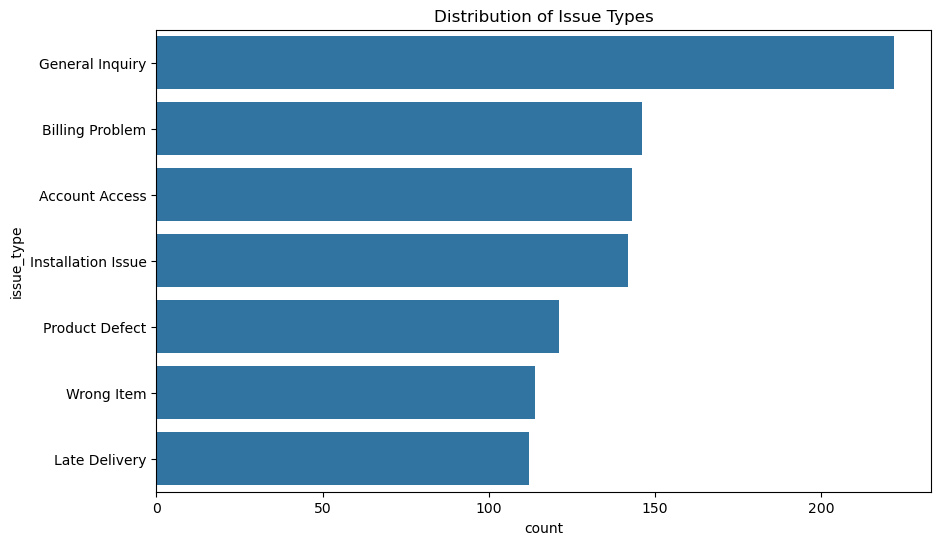

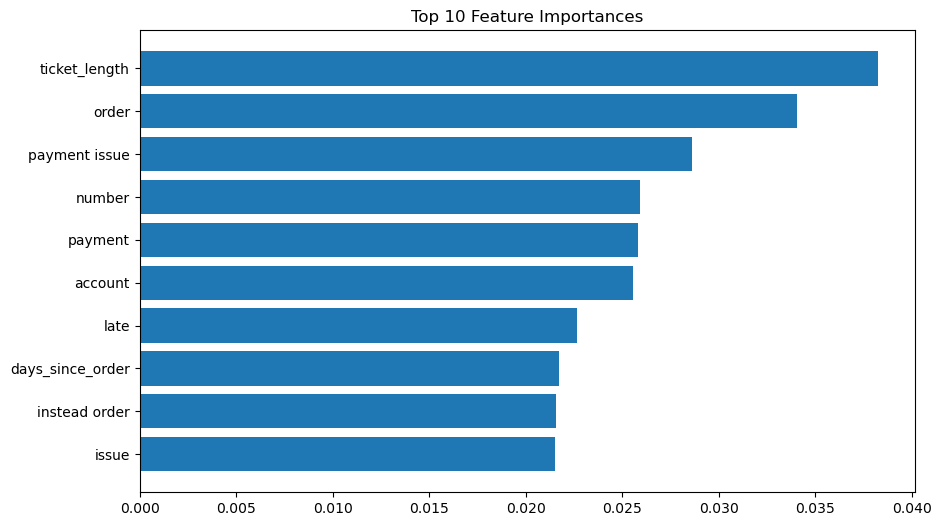

In [57]:
# Issue type distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='issue_type', data=data, order=data['issue_type'].value_counts().index)
plt.title('Distribution of Issue Types')
plt.show()

# Feature importance
rf_pipeline = issue_pipelines['Random Forest']
feature_names = (rf_pipeline.named_steps['preprocessor'].named_transformers_['text'].get_feature_names_out().tolist() +
                 rf_pipeline.named_steps['preprocessor'].named_transformers_['product'].get_feature_names_out().tolist() +
                 ['ticket_length', 'sentiment_score', 'keyword_count', 'exclamation_count', 
                  'has_order_number', 'text_complexity', 'days_since_order', 'has_billing_keyword'])
importances = rf_pipeline.named_steps['classifier'].feature_importances_
top_indices = np.argsort(importances)[-10:]
plt.figure(figsize=(10, 6))
plt.barh([feature_names[i] for i in top_indices], importances[top_indices])
plt.title('Top 10 Feature Importances')
plt.show()